In [12]:

import sys
sys.path.append('/home/shenqi/Master_thesis/SEED')
from Model.feature_extractor import EMinGRU_ReLUFuseDownsampleConv_ConditionalConv,EMinGRU_ReLUFuseDownsampleConv_EventConv
from Model.ssd_head import BoxHead
from metavision_ml.detection.anchors import Anchors
from utils.dataloader import seq_dataloader
import utils.data_augmentation as data_aug
from Model.detection import inference_step
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm
import numpy as np


dataset_path = '/media/shenqi/data/Gen4_multi_timesurface_FromDat'
dataset_path = '/media/shenqi/data/Gen4_multi_timesurface_FromDat_super_small'
dataset_type = 'gen4'
dataloader = seq_dataloader(dataset_path = dataset_path, dataset_type = dataset_type, num_tbins = 1, batch_size = 1, channels = 6)

cout = 256
threshold_group = 1
conditional_net = EMinGRU_ReLUFuseDownsampleConv_ConditionalConv(dataloader.channels, base=int(cout/16), cout=cout, dataset = dataset_type, pruning = False)
conditional_box_coder = Anchors(num_levels=conditional_net.levels, anchor_list='PSEE_ANCHORS', variances=[0.1, 0.2])
conditional_ssd_head = BoxHead(conditional_net.cout, conditional_box_coder.num_anchors, len(dataloader.wanted_keys)+1, n_layers=0)

conditional_net.load_state_dict(torch.load('/home/shenqi/Master_thesis/SEED/Saved_Model/new_gen4/EMinGRU_ReLUFuseDownsampleConv_ConditionalConv_256_norelu_n15b8/48_model.pth',map_location=torch.device('cuda')))
conditional_ssd_head.load_state_dict(torch.load('/home/shenqi/Master_thesis/SEED/Saved_Model/new_gen4/EMinGRU_ReLUFuseDownsampleConv_ConditionalConv_256_norelu_n15b8/48_pd.pth',map_location=torch.device('cuda')))

conditional_net.eval().to('cuda')
conditional_ssd_head.eval().to('cuda')
######################################################################################################################################
event_net = EMinGRU_ReLUFuseDownsampleConv_EventConv(dataloader.channels, base=int(cout/16), cout=cout, dataset = dataset_type, pruning = False)
event_box_coder = Anchors(num_levels=event_net.levels, anchor_list='PSEE_ANCHORS', variances=[0.1, 0.2])
event_ssd_head = BoxHead(event_net.cout, event_box_coder.num_anchors, len(dataloader.wanted_keys)+1, n_layers=0)

event_net.load_state_dict(torch.load('/home/shenqi/Master_thesis/SEED/Saved_Model/new_gen4/EMinGRU_ReLUFuseDownsampleConv_EventConv/44_model.pth',map_location=torch.device('cuda')))
event_ssd_head.load_state_dict(torch.load('/home/shenqi/Master_thesis/SEED/Saved_Model/new_gen4/EMinGRU_ReLUFuseDownsampleConv_EventConv/44_pd.pth',map_location=torch.device('cuda')))

event_net.eval()#.to('cuda')
event_ssd_head.eval()#.to('cuda')
def plot_parameters(model):
    cnt = 0
    for name, param in model.named_parameters() :
        if param.requires_grad:
            if name.endswith('thr_reparam'):
            # if name.split('.')[-1] == 'thr_reparam':
                cnt += 1
                # if cnt > 9:
                #     break
                # plt.figure(figsize=(6,6))
                print(param.shape)
                param = param.detach().numpy()
                param= 1 / (1 + np.exp(-1 * param))
            
                plt.imshow(param, cmap='viridis') 
                plt.colorbar()
                
                
                # plt.title(name)
                # plt.hist((param).data.cpu().numpy().flatten(), bins=500)
                # plt.xticks(fontsize=14)
                # plt.yticks(fontsize=14)
                plt.show()
                # raise Exception

torch.Size([180, 320])


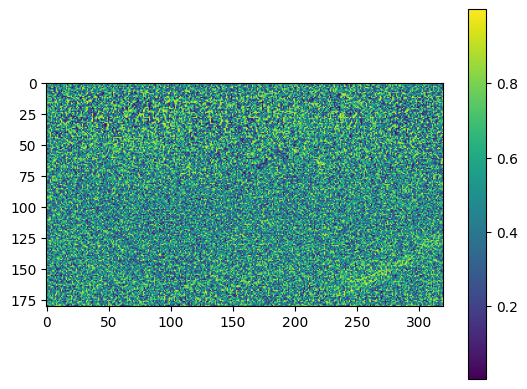

torch.Size([180, 320])


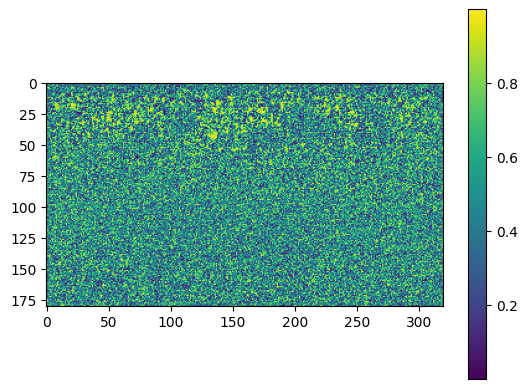

torch.Size([90, 160])


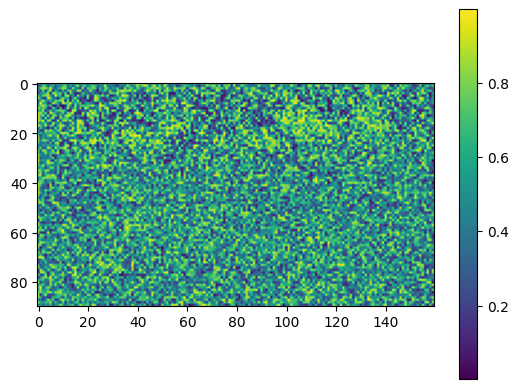

torch.Size([90, 160])


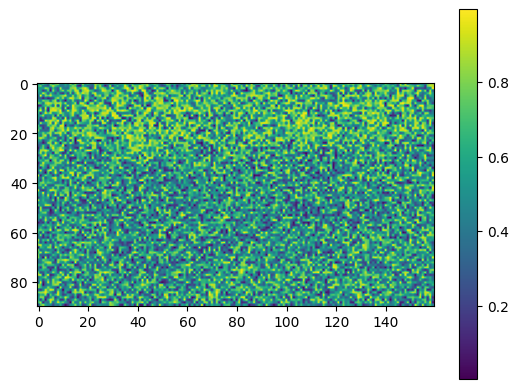

torch.Size([90, 160])


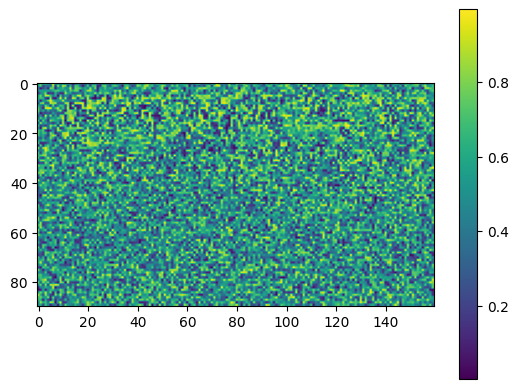

torch.Size([90, 160])


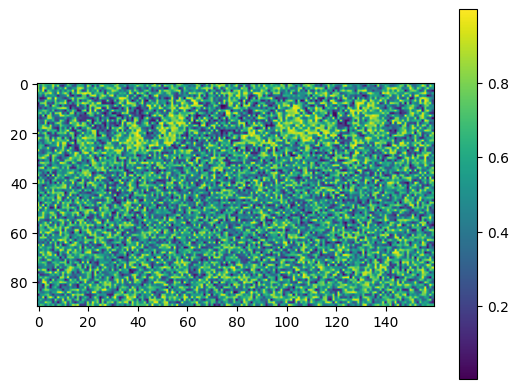

torch.Size([90, 160])


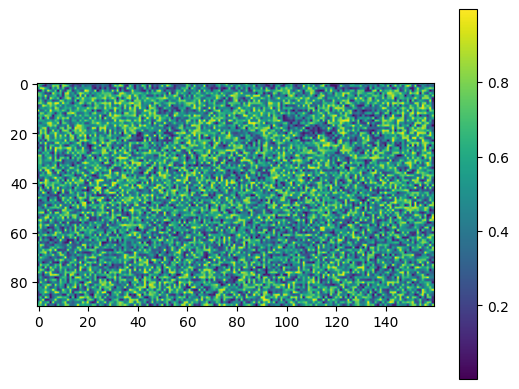

torch.Size([90, 160])


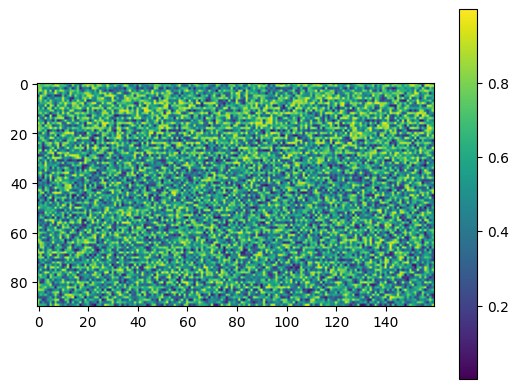

torch.Size([90, 160])


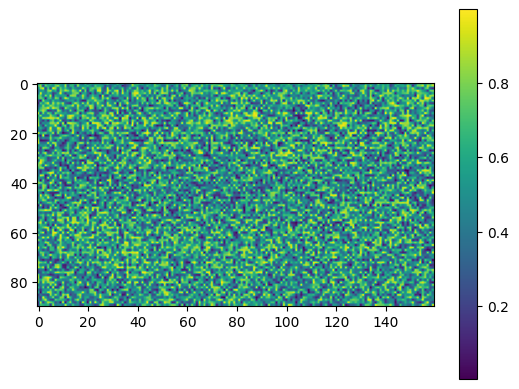

torch.Size([256, 45, 80])


TypeError: Invalid shape (256, 45, 80) for image data

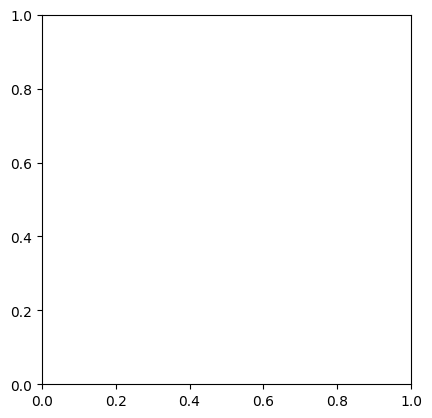

In [13]:

plot_parameters(event_net)


In [7]:
# output_val_list = []
# cnt_val = 0
# mean_activity_egru_ave = [0] * event_net.levels
# events_conv1 = torch.zeros([180, 320])
# mean_activity_egruRelu_ave = [0] * event_net.levels
# box_hid_mean_ave = [0] * event_net.levels
# cls_hid_mean_ave = [0] * event_net.levels
# receptive_field_input = torch.zeros((7,360,640))
# augment = data_aug.data_augmentation(dataset_type= dataset_type)
# event_net.eval().to('cuda')
# event_ssd_head.eval().to('cuda')
# with tqdm(total=len(dataloader.seq_dataloader_test), desc=f'Validation',ncols=120) as pbar:
            
#     for data in dataloader.seq_dataloader_test:
#         sys.stdout.flush()
#         with torch.no_grad():
#             cnt_val += 1
#             if cnt_val>20:
#                 raise Exception
#             data['inputs'] = data['inputs'].to(device='cuda')
#             # if data['frame_is_labeled'].sum().item() != 0:
#             #     data = augment(data, only_vertical_move=True)  
#             output_val, mean_activity, mean_activity_conv1, output_gates_val_conv1, mean_activity_egru_relu, box_hid_mean, cls_hid_mean = inference_step(data,event_net,event_ssd_head,event_box_coder)
#             events_conv1 += output_gates_val_conv1[0].detach().cpu()
#             plt.imshow(events_conv1, cmap='viridis') 
#             pbar.update(1)

In [8]:
output_val_list = []
cnt_val = 0
mean_activity_egru_ave = [0] * event_net.levels
thr_conv1 = torch.zeros([180, 320])
mean_activity_egruRelu_ave = [0] * event_net.levels
box_hid_mean_ave = [0] * event_net.levels
cls_hid_mean_ave = [0] * event_net.levels
receptive_field_input = torch.zeros((7,360,640))
augment = data_aug.data_augmentation(dataset_type= dataset_type)
event_net.eval().to('cuda')
event_ssd_head.eval().to('cuda')
with tqdm(total=len(dataloader.seq_dataloader_test), desc=f'Validation',ncols=120) as pbar:
            
    for data in dataloader.seq_dataloader_test:
        sys.stdout.flush()
        with torch.no_grad():
            cnt_val += 1
           
            data['inputs'] = data['inputs'].to(device='cuda')
            if data['frame_is_labeled'].sum().item() != 0:
                data = augment(data, only_vertical_move=True)  
            
            features, events, neg_dis, conv1_outs, egruReluouts, raw_thr = conditional_net(data['inputs'])
            
            thr_conv1 += raw_thr[0][0].detach().cpu()
            
            if cnt_val > 100 and cnt_val % 100==0:
                plt.imshow(thr_conv1, cmap='viridis') 
                plt.colorbar()
                plt.show()
                
            pbar.update(1)

Validation:   0%|                                                                              | 0/2400 [00:00<?, ?it/s]

/home/shenqi/Master_thesis/venv_master_thesis/lib/python3.10/site-packages/torch/nn/modules/conv.py:456: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return F.conv2d(input, weight, bias, self.stride,
Validation:   0%|                                                                              | 0/2400 [00:00<?, ?it/s]


ValueError: not enough values to unpack (expected 6, got 5)